In [114]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import sys
#sys.path.append('/Users/arthurbabey/Documents/master2/ML/road66/scripts')
sys.path.append('C:/Users/joeld/Desktop/EPFL/machine learning/road66/scripts')
from helpers import *
import lightgbm as lgb
import sklearn as skl


In [79]:
# Loaded a set of images
root_dir = "../Datasets/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files) # Use all images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


In [80]:
import skimage as skimg
#data augmentation (rotated imgs)
imgs = np.array(imgs)
gt_imgs = np.array(gt_imgs)

rotimg = np.zeros(imgs.shape)
rotgtimg = np.zeros(gt_imgs.shape)
for i in range(len(imgs)):
    rotimg[i] = skimg.transform.rotate(imgs[i], 45, resize=False, mode='reflect')
    rotgtimg[i] = skimg.transform.rotate(gt_imgs[i], 45, resize=False, mode='reflect')

imgs = np.concatenate([imgs,rotimg])
gt_imgs = np.concatenate([gt_imgs,rotgtimg])

In [111]:
# 
# Preparation training data
# 


# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

# Extract features
#X2d = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
#X3d = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
#X_filter = np.asarray([ fanny_filter(img_patches[i]) for i in range(len(img_patches))])
#X = np.concatenate((X2d, X3d), axis = 1)
X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])





# Features augmentation 
X = poly_augmentation(X, 2)


#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X = sc.fit_transform(X)



# Extract labels
#foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

[0 0 0 ... 0 0 1]


In [82]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 62500 features
Feature dimension = 28
Number of classes = 1
Class 0: 46308 samples
Class 1: 16192 samples


In [112]:
d_train = lgb.Dataset(X, label=Y)

params = {}
params['learning_rate'] = 0.0003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 100
params['min_data'] = 50
params['max_depth'] = 50


clf = lgb.train(params, d_train, 100)

(62500, 28)


In [142]:
# test randomcv
classif = lgb.LGBMClassifier()

params = {

        'bagging_fraction': (0.5, 0.8),
        'bagging_frequency': (5, 8),

        'feature_fraction': (0.5, 0.8),
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
        'min_data_in_leaf': [1, 10, 20,30,50],
        'num_leaves': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110,200,500,700,1000]

}

clf = skl.model_selection.RandomizedSearchCV(classif, params)
best_model = clf.fit(X, Y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [137]:
print(params['bagging_fraction'])

(0.5, 0.8)


100


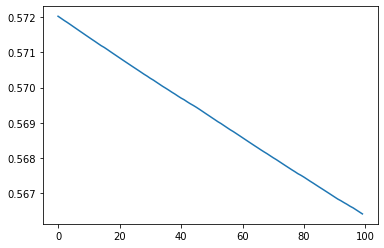

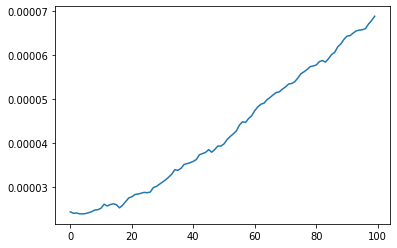

In [109]:
mean = cv_results['binary_logloss-mean']
std = cv_results['binary_logloss-stdv']
x = np.linspace(0,len(mean)-1,len(mean))
print(len(x))
plt.plot(x, mean)
plt.figure()
plt.plot(x,std)

In [143]:
# 
# Ordering image
# 
root_testdir = "../Datasets/test_set_images"
test_names = os.listdir(root_testdir)

num_test = len(test_names)
order = [int(test_names[i].split("_")[1]) for i in range(num_test)]
index = np.argsort(order)

# Load image and reorder them
imgs_test = [load_image(os.path.join(root_testdir, test_names[i], test_names[i]) + ".png") for i in range(num_test)]
imgs_test = [imgs_test[i] for i in index]

# Crop images in patch and Linearize list of patches
patch_size = 16 # each patch is 16*16 pixels

img_patches_test = [img_crop(imgs_test[i], patch_size, patch_size) for i in range(num_test)]


# Linearize list of patches
img_patches_test = np.asarray([img_patches_test[i][j] for i in range(len(img_patches_test)) for j in range(len(img_patches_test[i]))])



# Extract, augment & standardize features
#X2dtest = np.asarray([ extract_features_2d(img_patches_test[i]) for i in range(len(img_patches_test))])
#X3dtest = np.asarray([ extract_features(img_patches_test[i]) for i in range(len(img_patches_test))])

#Xtest = np.concatenate((X2dtest, X3dtest), axis = 1)

Xtest = np.asarray([ extract_features(img_patches_test[i]) for i in range(len(img_patches_test))])

#features augmentation



Xtest = poly_augmentation(Xtest, 2)


#Xtest = sc.transform(Xtest)


# 
# Prediction 
# 

#pred = clf.predict(Xtest)
pred = best_model.predict(Xtest)


for i in range(0,len(pred)):
    if pred[i]>=.26:       # setting threshold to .5
        pred[i]=1
    else:  
        pred[i]=0

# 
# Save prediction
# 
create_submission(pred, "logreg_submission.csv")

[0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

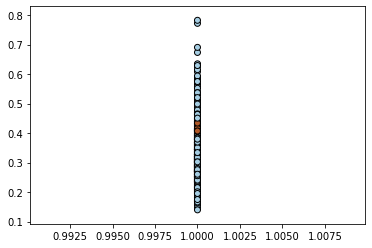

In [154]:
# Run prediction on the img_idx-th image
img_idx = 60


Xi = extract_img_features(image_dir + files[img_idx])
Xi = poly_augmentation(Xi, 2)


#Prediction
#Zi=clf.predict(Xi)
Zi=best_model.predict(Xi)#convert into binary values
print(Zi)
for i in range(0,len(Zi)):
    if Zi[i]>=.25:       # setting threshold to .26
        Zi[i]=1
    else:  
        Zi[i]=0


plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)
print(Zi)

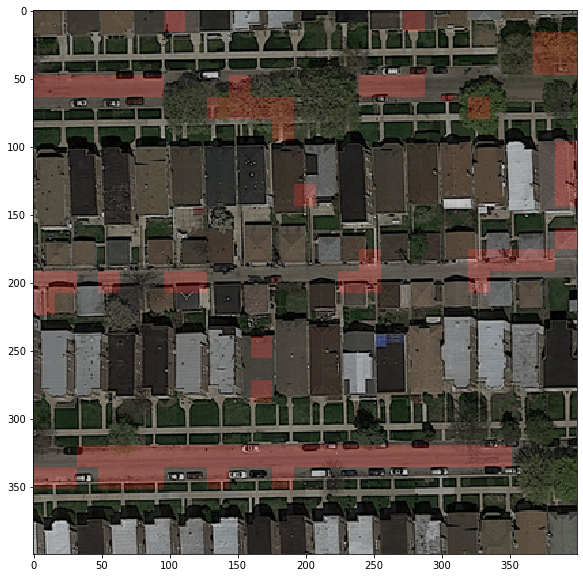

In [155]:
# Display prediction as an image
"""""
ca marche pas encore très bien.. ahah

"""""

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)